In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer
import joblib
import gradio as gr

In [23]:
# Configurations
RANDOM_STATE = 42
TEST_SIZE = 0.2
MODEL_PATH = "titanic_model.joblib"

### Dataset exploration

In [24]:
# Data loading and little exploration
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

In [25]:
# first few rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
# columns and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
# statistical analysis of data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
# shape of dataset
df.shape

(891, 12)

In [29]:
# null values from dataset
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [30]:
# Survival rate
((df['Survived'].mean()) * 100).round(2)

np.float64(38.38)

### Data Processing

In [31]:
"""
Here we need only columns [Pclass, sex, age, sibsp, parch, fare and embarked] for prediction
So avoiding the column cabin even though it has 100's missing values
"""
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

df = df.dropna(subset=['Embarked'])

In [32]:
# assigning X and y features
X = df[features]
y = df['Survived']

In [33]:
X.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
7,3,male,2.0,3,1,21.0750,S
8,3,female,27.0,0,2,11.1333,S
9,2,female,14.0,1,0,30.0708,C


In [34]:
y.head(10)

,Survived
0,0
1,1
2,1
3,1
4,0
5,0
6,0
7,0
8,1
9,1


### Train-test-split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = y
)

In [43]:
print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (711, 7)
Test size : (178, 7)


***Tiny visual intuition of stratify***

Imagine 10 samples:

```
Survived:     4
Not survived: 6
```


Without stratify (random):
```
Train: 1 survived, 5 not
Test:  3 survived, 1 not  ❌
```

With stratify:
```
Train: 3 survived, 5 not
Test:  1 survived, 1 not  
```

### Building Processing pipeline

In [44]:
"""Building a processing pipeline"""

# Impute Numeric features with mean and then scale them!
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Why these features?

- Age - Continuous (0-80 years)
- Fare - Continuous ticket price (highly variable: £0-£512)
- SibSp - Count of siblings/spouses (0-8)
- Parch - Count of parents/children (0-6)

Step 1: SimpleImputer(strategy='median')

- What it does: Fills missing values (mainly Age has 177 nulls)
- Why median? More robust than mean - not affected by extreme outliers (like very old passengers or very high fares)
- Example: If Age has nulls, fills them with ~28 (median age)

Step 2: StandardScaler()

- What it does: Transforms features to have mean=0, std=1
- Why? Features have very different scales:

  - Age: 0-80
  - Fare: 0-512
  - SibSp: 0-8


- Math: scaled_value = (value - mean) / std_deviation
- Why it matters: Many algorithms (though not Random Forest) are sensitive to scale. It's still good practice and allows model comparison later.


In [45]:
# Impute Categorical featurs with mode and then one-hot encode them!
categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

**Why these features?**
- **Pclass** - Passenger class (1=First, 2=Second, 3=Third) - proxy for wealth
- **Sex** - Male/Female - critical predictor (women had priority in lifeboats)
- **Embarked** - Port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)

**Step 1: SimpleImputer(strategy='most_frequent')**
- **What it does:** Fills missing values with the most common category
- **Why most_frequent?** Can't use mean/median for text categories
- **Example:** Embarked has 2 nulls → fills with 'S' (Southampton, the most common)

**Step 2: OneHotEncoder(drop='first', handle_unknown='ignore')**
- **What it does:** Converts categories to binary columns

**Example transformation:**
```
Sex: ['male', 'female', 'male']
→ Sex_male: [1, 0, 1]
```

**Why drop='first'?**

- Avoids dummy variable trap (multicollinearity)
- If you have Sex_male and Sex_female, they're perfectly correlated:

  - Sex_male=1 always means Sex_female=0
  - This creates redundancy


- With drop='first': Keep only Sex_male (0=female, 1=male)

- Why handle_unknown='ignore'?

  - If new data has unseen categories (e.g., Embarked='T'), don't crash
  - Creates all-zeros for that sample
  - Production safety: Model won't break on unexpected data



In [46]:
# Combine transformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

**What it does:**
- Applies different transformations to different column types **simultaneously**
- Combines results into one feature matrix

**Visual representation:**
```
Input DataFrame:
┌─────┬─────┬─────┬────────┬─────────┐
│ Age │Fare │Pclass│  Sex   │Embarked │
├─────┼─────┼─────┼────────┼─────────┤
│ 22  │ 7.25│  3  │ male   │    S    │
│ NaN │ 71  │  1  │ female │    C    │
└─────┴─────┴─────┴────────┴─────────┘

After ColumnTransformer:
┌────────┬────────┬──────┬──────┬──────────┬──────────┬─────────┬─────────┐
│Age_std │Fare_std│SibSp │Parch │Pclass_2  │Pclass_3  │Sex_male │Embarked_Q│...
├────────┼────────┼──────┼──────┼──────────┼──────────┼─────────┼─────────┤
│ -0.53  │ -0.50  │  0   │  0   │    0     │    1     │    1    │    0    │
│  0.64  │  0.79  │  1   │  0   │    0     │    0     │    0    │    0    │
└────────┴────────┴──────┴──────┴──────────┴──────────┴─────────┴─────────┘

In [58]:
# Full pipeline with model
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced",n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,random_state=RANDOM_STATE))
])


In [59]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        random_state=42))])

### Model training

In [60]:
print("training model....")
model.fit(X_train, y_train)
print("training complete....")

training model....
training complete....


### Model evaluation

In [62]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [63]:
print("Classification Report")
print(classification_report(y_test, y_pred, target_names=["Did not survive", "Survived"]))

Classification Report
                 precision    recall  f1-score   support

Did not survive       0.86      0.86      0.86       110
       Survived       0.78      0.78      0.78        68

       accuracy                           0.83       178
      macro avg       0.82      0.82      0.82       178
   weighted avg       0.83      0.83      0.83       178



In [65]:
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC score: {roc_auc}")

ROC-AUC score: 0.831951871657754


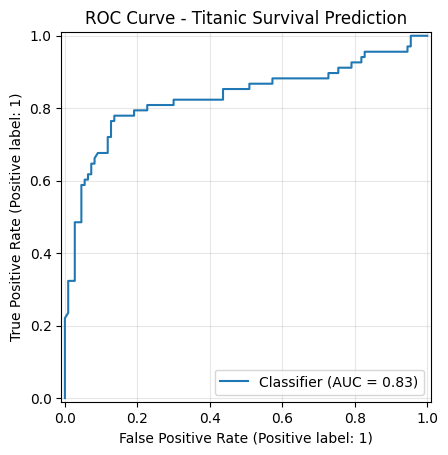

In [66]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Titanic Survival Prediction")
plt.grid(alpha=0.3)
plt.show()

### Save model + export predictions

In [67]:
joblib.dump(model, MODEL_PATH)
print(f"Model saved as {MODEL_PATH}")

Model saved as titanic_model.joblib


In [68]:
predictions_df = pd.DataFrame({
    "True_Label": y_test.values,
    "Predicted":y_pred,
    "Survival_Prob":y_prob
})

In [69]:
predictions_df.to_csv("pred.csv", index=False)
print("CSV exported")

CSV exported


### Simple Gradio Inference

In [70]:
def predict_survival(Pclass, Sex, Age, SibSp, Parch, Fare, Embarked):
    sample = pd.DataFrame([{
        "Pclass": Pclass,
        "Sex": Sex,
        "Age": Age,
        "SibSp": SibSp,
        "Parch": Parch,
        "Fare": Fare,
        "Embarked": Embarked
    }])

    pred = model.predict(sample)[0]
    prob = model.predict_proba(sample)[0][1]

    label = "✅ Survived" if pred == 1 else "❌ Did Not Survive"
    return f"{label}\nSurvival Probability: {prob:.2%}"


In [71]:
demo = gr.Interface(
    fn=predict_survival,
    inputs=[
        gr.Dropdown([1, 2, 3], value=3, label="Passenger Class"),
        gr.Radio(["male", "female"], value="male", label="Sex"),
        gr.Slider(0, 80, value=30, label="Age"),
        gr.Slider(0, 8, value=0, step=1, label="Siblings / Spouses"),
        gr.Slider(0, 6, value=0, step=1, label="Parents / Children"),
        gr.Slider(0, 512, value=32, label="Fare"),
        gr.Dropdown(["C", "Q", "S"], value="S", label="Embarked")
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="🚢 Titanic Survival Predictor",
    description="Simple ML inference demo using scikit-learn pipeline",
    examples=[
        [1, "female", 28, 0, 0, 100, "C"],
        [3, "male", 22, 1, 0, 7, "S"]
    ]
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://680b23bf2024f90bb4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
